# Settings

## Library Import

In [53]:
import warnings
warnings.simplefilter('ignore')

import datetime
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedShuffleSplit
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.inspection import permutation_importance, partial_dependence
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

# Data Load

In [13]:
train = pd.read_csv("train_20240719.csv")

In [14]:
train.head()

,date,hour,crawds_level,weekday,arena_start_time_in_0,arena_max_price_0,arena_min_price_0,arena_num_of_people_0,arena_start_time_in_1,arena_max_price_1,...,garden_theater_num_of_people_1,garden_theater_start_time_in_2,garden_theater_max_price_2,garden_theater_min_price_2,garden_theater_num_of_people_2,temperature,humidity,cloud,chance_of_rain,weather
0,2024-05-24,8,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.4,70,8,0,1
1,2024-05-24,9,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.0,66,92,0,2
2,2024-05-24,10,2,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,22.6,62,100,0,2
3,2024-05-24,11,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.7,57,100,0,2
4,2024-05-24,12,1,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,24.8,53,100,0,2


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            825 non-null    object 
 1   hour                            825 non-null    int64  
 2   crawds_level                    825 non-null    int64  
 3   weekday                         825 non-null    int64  
 4   arena_start_time_in_0           375 non-null    float64
 5   arena_max_price_0               315 non-null    float64
 6   arena_min_price_0               315 non-null    float64
 7   arena_num_of_people_0           375 non-null    float64
 8   arena_start_time_in_1           150 non-null    float64
 9   arena_max_price_1               150 non-null    float64
 10  arena_min_price_1               150 non-null    float64
 11  arena_num_of_people_1           150 non-null    float64
 12  arena_start_time_in_2           30 n

# Preprocessing

# Feature Engineering

## 混雑状況(目的変数)を２値化

In [16]:
train["crawds_level_binary"] = False
train["crawds_level_binary"] = train["crawds_level"]==3

## 休日フラグ

In [17]:
# 祝日リスト
holiday_list = ["2024-01-01","2024-01-08","2024-02-11","2024-02-12","2024-02-23","2024-03-20","2024-04-29","2024-05-03","2024-05-04","2024-05-05","2024-05-06","2024-07-15","2024-08-11","2024-08-12","2024-09-16","2024-09-22","2024-09-23","2024-10-14","2024-11-03","2024-11-04","2024-11-23"]

In [18]:
train["holiday"]=False
for index, row in train.iterrows():
    # 土日
    if train.loc[index,"weekday"] == 5 or train.loc[index,"weekday"] == 6:
        train.loc[index, "holiday"] = True
    # 祝日
    if train.loc[index, "date"] in holiday_list:
        train.loc[index, "holiday"] = True

## イベント有無

In [19]:
train["event"] = False
for index, row in train.iterrows():
    if not (np.isnan(train.loc[index, "arena_start_time_in_0"])):
        train.loc[index, "event"] = True
    if not (np.isnan(train.loc[index, "garden_theater_start_time_in_0"])):
        train.loc[index, "event"] = True

## カテゴリ変数

#### weather

In [21]:
train = pd.get_dummies(train, columns=["weather"])

## 説明変数設定

In [22]:
train.columns

Index(['date', 'hour', 'crawds_level', 'weekday', 'arena_start_time_in_0',
       'arena_max_price_0', 'arena_min_price_0', 'arena_num_of_people_0',
       'arena_start_time_in_1', 'arena_max_price_1', 'arena_min_price_1',
       'arena_num_of_people_1', 'arena_start_time_in_2', 'arena_max_price_2',
       'arena_min_price_2', 'arena_num_of_people_2',
       'garden_theater_start_time_in_0', 'garden_theater_max_price_0',
       'garden_theater_min_price_0', 'garden_theater_num_of_people_0',
       'garden_theater_start_time_in_1', 'garden_theater_max_price_1',
       'garden_theater_min_price_1', 'garden_theater_num_of_people_1',
       'garden_theater_start_time_in_2', 'garden_theater_max_price_2',
       'garden_theater_min_price_2', 'garden_theater_num_of_people_2',
       'temperature', 'humidity', 'cloud', 'chance_of_rain',
       'crawds_level_binary', 'holiday', 'event', 'weather_1', 'weather_2',
       'weather_3', 'weather_4'],
      dtype='object')

In [27]:
feature_cols = train.columns.tolist()
feature_cols.remove("date")
feature_cols.remove("crawds_level")
feature_cols.remove("weekday")
feature_cols.remove("crawds_level_binary")

# Training

In [28]:
target_col="crawds_level_binary"

In [35]:
kf = StratifiedKFold(
    n_splits = 4,
    random_state = 42,
    shuffle=True
)
train['fold']=-1

for fold, (t,v) in enumerate(kf.split(train, train[target_col])):
    train.loc[v, 'fold'] = fold+1

train['fold'] = train['fold'].astype('int')
display(train.groupby('fold')[target_col].agg('sum').reset_index())

,fold,crawds_level_binary
0,1,31
1,2,30
2,3,31
3,4,31


In [36]:
print(f'feature_cols: {len(feature_cols)}')

feature_cols: 35


In [37]:
def calc_metric(y_true, y_pred, th=0.5):
    y_pred = np.where(y_pred>th,1,0)
    score = f1_score(y_true, y_pred, average='macro')
    return score

In [58]:
oof = np.zeros(len(train))
imp_dfs = []

for fold in range(4):
    print(f'∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞ Fold{fold+1} ∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞')

    # Data Split
    tr_idx = train[train['fold']!=fold+1].index.tolist()
    va_idx = train[train['fold']==fold+1].index.tolist()

    X_train = train.loc[tr_idx, :]
    X_valid = train.loc[va_idx, :]
    y_train = train.loc[tr_idx, target_col]
    y_valid = train.loc[va_idx, target_col]

    X_train = X_train[feature_cols]
    X_valid = X_valid[feature_cols]
    print(f'X_train: {X_train.shape}, X_valid: {X_valid.shape}')

    model = LGBMClassifier(verbose=-1)
    
    if False:
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            wandb_callback(),
        ]
    else:
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
        ]
        
    # 学習 -> fitで実施
    model.fit(
        X_train,
        y_train,
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        # eval_names = [f"fold{fold+1}/{c}/train", f"fold{fold+1}/{c}/valid"],
        feature_name = X_train.columns.tolist(),
#            verbose = -1,
        callbacks = callbacks
    )
    
    # validationに対する評価
    valid_pred = model.predict_proba(X_valid)[:,1]
    valid_pred_binary = model.predict(X_valid)
    # valid_score = calc_metric(y_valid, valid_pred, th=0.5)
    # print(f"  Fold{fold+1} Score: {valid_score:.5f}")
    print(confusion_matrix(y_valid, valid_pred_binary))
    print("acc:{:3f}, pre:{:3f}, rec:{:3f}, f1:{:3f}".format(accuracy_score(y_valid, valid_pred_binary), precision_score(y_valid, valid_pred_binary), recall_score(y_valid, valid_pred_binary), f1_score(y_valid, valid_pred_binary)))
    oof[va_idx] += valid_pred
    
    # Feature Importance
    # Gain Importance, Permutation Importance の値を取得
    f_imp = model.feature_importances_
    tmp_importance = pd.DataFrame()
    tmp_importance["feature"] = feature_cols
    tmp_importance["gain"] = f_imp
    tmp_importance["fold"] = fold+1
    imp_dfs.append(tmp_importance)
    
    # 学習したモデルを保存 -> save
    MODEL_PATH = f"model/baseline_fold{fold+1}_model.pkl"
    pickle.dump(model, open(MODEL_PATH, 'wb'))
    
c_score = calc_metric(train[target_col], oof[:])
print(f'★ {c_score:.5f}')
    
imp_df = pd.concat(imp_dfs, axis=0, ignore_index=True)

∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞ Fold1 ∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞
X_train: (618, 35), X_valid: (207, 35)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	training's binary_logloss: 0.171762	valid_1's binary_logloss: 0.308533
[[171   5]
 [ 23   8]]
acc:0.864734, pre:0.615385, rec:0.258065, f1:0.363636
∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞ Fold2 ∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞
X_train: (619, 35), X_valid: (206, 35)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[21]	training's binary_logloss: 0.164059	valid_1's binary_logloss: 0.255387
[[167   9]
 [ 14  16]]
acc:0.888350, pre:0.640000, rec:0.533333, f1:0.581818
∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞ Fold3 ∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞∞
X_train: (619, 35), X_valid: (206, 35)
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	training's binary_logloss: 0.101191	valid_1's binary_logloss: 0.215914
[[169   6]
 [ 1

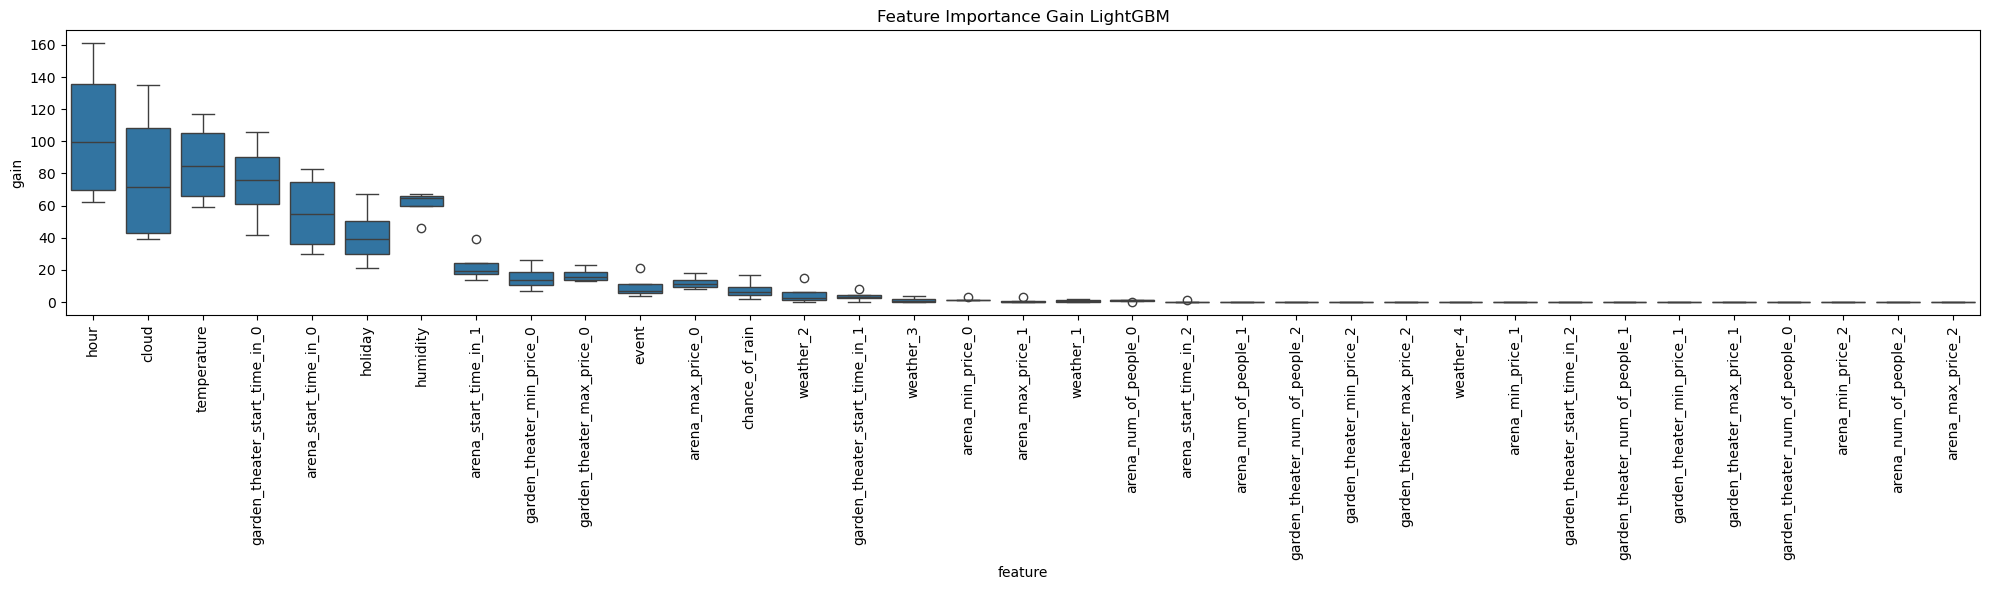

In [47]:
# Feature Importance
mean_importance = imp_df.groupby('feature')['gain'].agg('mean')
mean_importance - mean_importance.sort_values(ascending=False)
importance_list = mean_importance.index.tolist()

plt.figure(figsize=(20,6), tight_layout=True)
sns.boxplot(
    data=imp_df[imp_df['feature'].isin(importance_list)].sort_values('gain', ascending=False),
    x='feature',
    y='gain'
)
plt.xticks(rotation=90)
plt.title("Feature Importance Gain LightGBM")
# plt.savefig(OUTPUT_DIR / "feature_importances.png")
plt.show()

In [49]:
# 閾値を 0~0.9まで0.1刻みで振ってみる

oof_preds = []
oof_labels = []

oof_scores = []
ths = []

for i in range(10):
    th = i/10
    
    oof_preds.extend(list(oof[:]))
    oof_labels.extend(train['crawds_level_binary'].tolist())
    
    prauc = average_precision_score(
        train['crawds_level_binary'],
        oof[:]
    )
    
    fscore = f1_score(
        train['crawds_level_binary'],
        [1 if i>th else 0 for i in oof[:]]
        , average='macro'
    )
        
    tmp_prauc = average_precision_score(
        oof_labels,
        oof_preds
    )
    
    tmp_fscore = f1_score(
        oof_labels,
        [1 if i>th else 0 for i in oof_preds]
        , average='macro'
    )
    print('+'*40)
    print(f'th{th:.2f} PRAUC: {tmp_prauc:.4f} F1Score: {tmp_fscore:.4f}')
    
    ths.append(th)
    oof_scores.append(tmp_fscore)

++++++++++++++++++++++++++++++++++++++++
th0.00 PRAUC: 0.6107 F1Score: 0.1297
++++++++++++++++++++++++++++++++++++++++
th0.10 PRAUC: 0.6107 F1Score: 0.7275
++++++++++++++++++++++++++++++++++++++++
th0.20 PRAUC: 0.6107 F1Score: 0.7863
++++++++++++++++++++++++++++++++++++++++
th0.30 PRAUC: 0.6107 F1Score: 0.7846
++++++++++++++++++++++++++++++++++++++++
th0.40 PRAUC: 0.6107 F1Score: 0.7789
++++++++++++++++++++++++++++++++++++++++
th0.50 PRAUC: 0.6107 F1Score: 0.7326
++++++++++++++++++++++++++++++++++++++++
th0.60 PRAUC: 0.6107 F1Score: 0.7169
++++++++++++++++++++++++++++++++++++++++
th0.70 PRAUC: 0.6107 F1Score: 0.6068
++++++++++++++++++++++++++++++++++++++++
th0.80 PRAUC: 0.6107 F1Score: 0.5264
++++++++++++++++++++++++++++++++++++++++
th0.90 PRAUC: 0.6107 F1Score: 0.4763


In [63]:
# oofの結果を保存
best_th = ths[np.argmax(oof_scores)]
best_score = np.max(oof_scores)

oof_df = pd.DataFrame(oof)
oof_df.to_csv(f'oof/baseline_oof_th{best_th:.2f}_{c_score:.4f}.csv', index=False)

### 結果検証

In [64]:
oof_df

,0
0,0.004277
1,0.027006
2,0.027006
3,0.012370
4,0.008323
...,...
820,0.454226
821,0.070312
822,0.029495
823,0.009431


In [69]:
oof_df.columns = ["oof"]

In [70]:
oof_df

,oof
0,0.004277
1,0.027006
2,0.027006
3,0.012370
4,0.008323
...,...
820,0.454226
821,0.070312
822,0.029495
823,0.009431


In [71]:
best_th

0.2

In [73]:
oof_df["pred"] = oof_df["oof"] > best_th

In [74]:
oof_df["pred"]

0      False
1      False
2      False
3      False
4      False
       ...  
820     True
821    False
822    False
823    False
824    False
Name: pred, Length: 825, dtype: bool

In [75]:
train_pred = pd.concat([train, oof_df], axis=1)

In [94]:
train_pred["correct"] = (train_pred["crawds_level_binary"] == train_pred["pred"])

[[620  82]
 [ 24  99]]
acc:0.871515, pre:0.546961, rec:0.804878, f1:0.651316


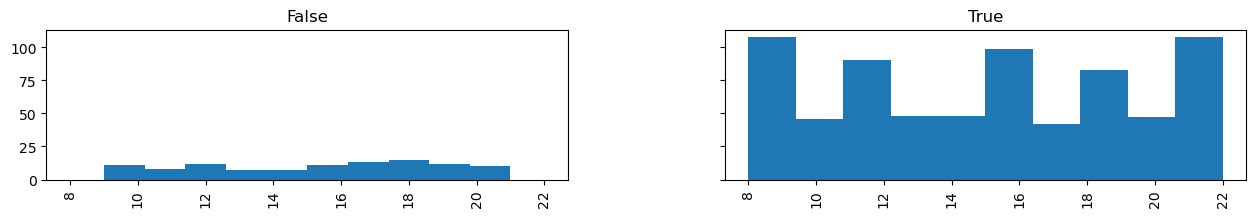

In [112]:
df = train_pred
y_valid = df["crawds_level_binary"]
valid_pred_binary = df["pred"]
print(confusion_matrix(y_valid, valid_pred_binary))
print("acc:{:3f}, pre:{:3f}, rec:{:3f}, f1:{:3f}".format(accuracy_score(y_valid, valid_pred_binary), precision_score(y_valid, valid_pred_binary), recall_score(y_valid, valid_pred_binary), f1_score(y_valid, valid_pred_binary)))
df[["hour","correct"]].hist(column="hour",by="correct", sharex=True, sharey=True)
plt.show()

In [95]:
train_noevent_weekday = train_pred[(train_pred["holiday"] != True) & (train_pred["event"] != True)]
train_event_weekday = train_pred[(train_pred["holiday"] != True) & (train_pred["event"] == True)]
train_noevent_holiday = train_pred[(train_pred["holiday"] == True) & (train_pred["event"] != True)]
train_event_holiday = train_pred[(train_pred["holiday"] == True) & (train_pred["event"] == True)]

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 2
plt.tight_layout()

---event:[False], holiday:[False]---
対象日数：18
[[268   0]
 [  2   0]]
acc:0.992593, pre:0.000000, rec:0.000000, f1:0.000000
〇正解ラベル=False(通常以下の混雑)


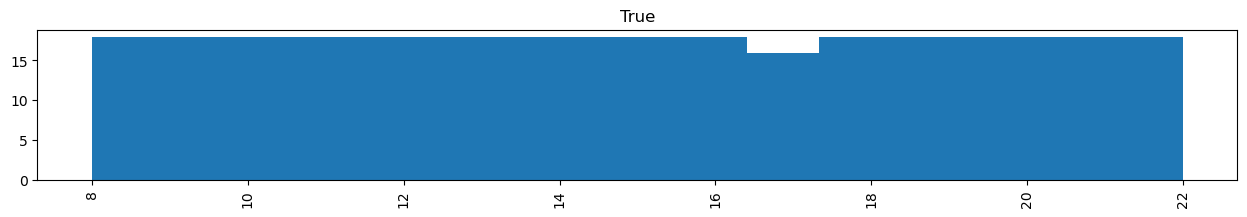

〇正解ラベル=True(混雑)


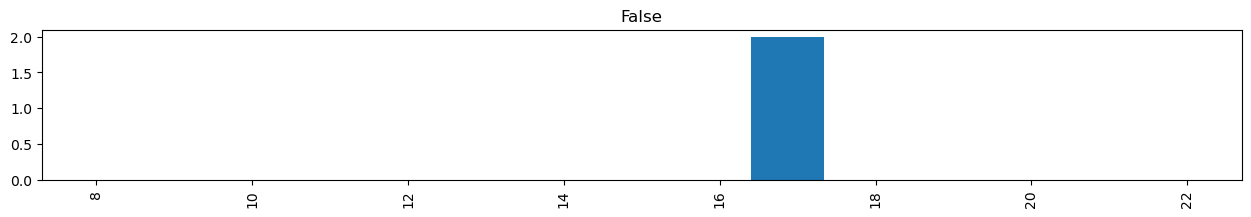

---event:[ True], holiday:[False]---
対象日数：20
[[255  17]
 [  9  19]]
acc:0.913333, pre:0.527778, rec:0.678571, f1:0.593750
〇正解ラベル=False(通常以下の混雑)


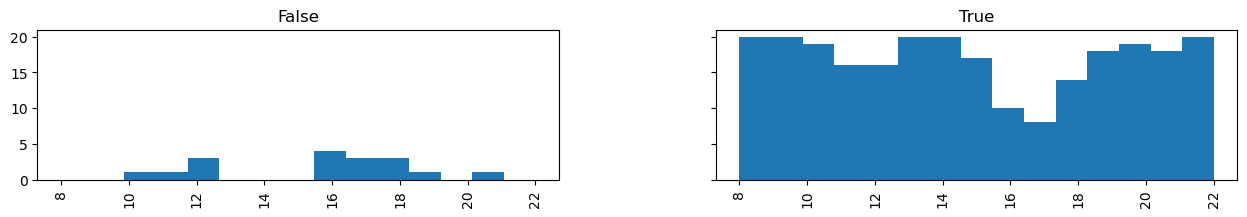

〇正解ラベル=True(混雑)


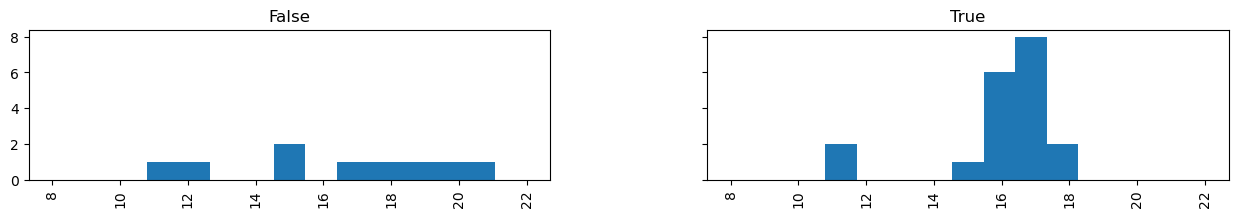

---event:[False], holiday:[ True]---
対象日数：2
[[11  9]
 [ 1  9]]
acc:0.666667, pre:0.500000, rec:0.900000, f1:0.642857
〇正解ラベル=False(通常以下の混雑)


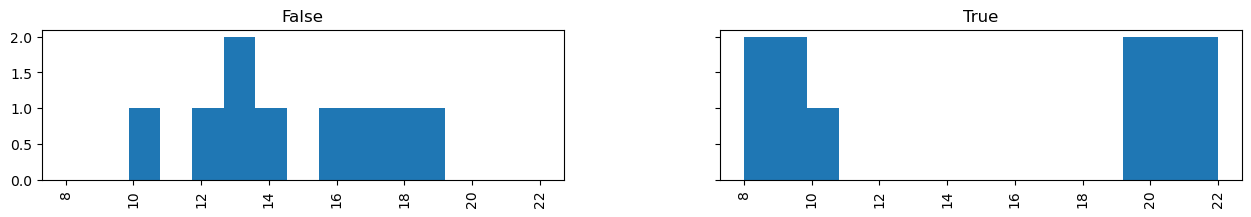

〇正解ラベル=True(混雑)


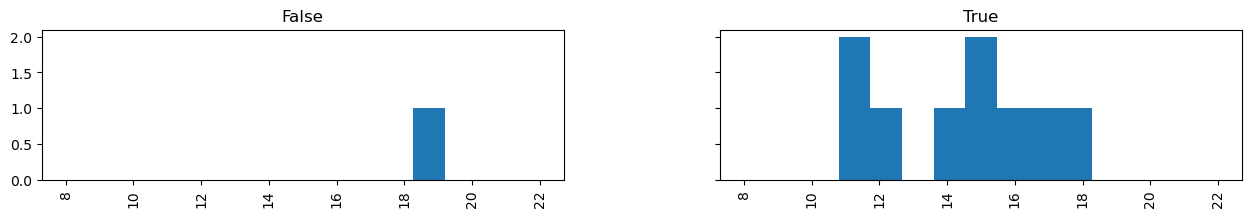

---event:[ True], holiday:[ True]---
対象日数：15
[[86 56]
 [12 71]]
acc:0.697778, pre:0.559055, rec:0.855422, f1:0.676190
〇正解ラベル=False(通常以下の混雑)


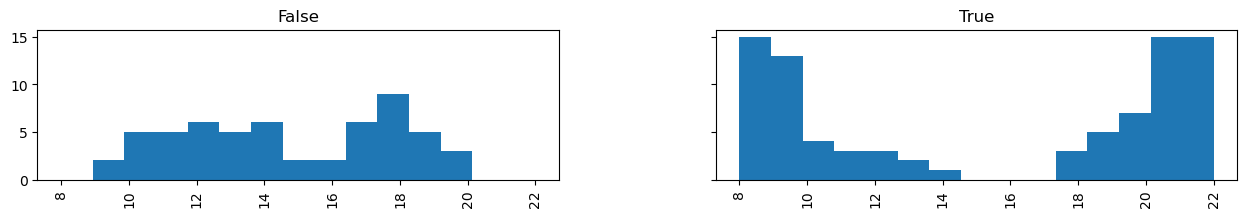

〇正解ラベル=True(混雑)


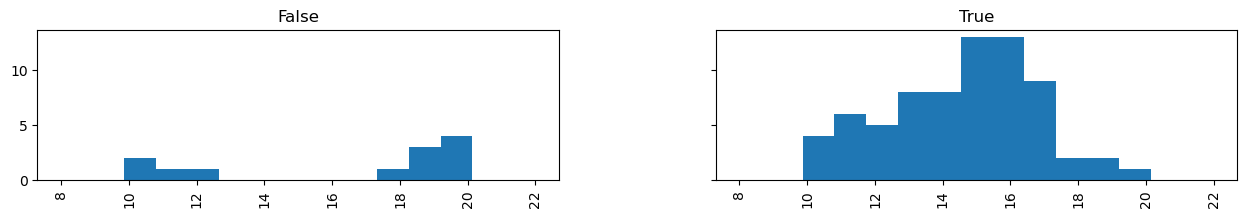

In [121]:
for df in [train_noevent_weekday, train_event_weekday, train_noevent_holiday, train_event_holiday]:
    y_valid = df["crawds_level_binary"]
    print("---event:{}, holiday:{}---".format(df["event"].unique(), df["holiday"].unique()))
    print("対象日数：{}".format(len(df["date"].unique())))
    valid_pred_binary = df["pred"]
    print(confusion_matrix(y_valid, valid_pred_binary))
    print("acc:{:3f}, pre:{:3f}, rec:{:3f}, f1:{:3f}".format(accuracy_score(y_valid, valid_pred_binary), precision_score(y_valid, valid_pred_binary), recall_score(y_valid, valid_pred_binary), f1_score(y_valid, valid_pred_binary)))
    print("〇正解ラベル=False(通常以下の混雑)")
    df[df["crawds_level_binary"]==False][["hour","correct"]].hist(column="hour",by="correct", sharex=True, sharey=True, bins=15, range=[8,22])
    plt.show()
    print("〇正解ラベル=True(混雑)")
    df[df["crawds_level_binary"]==True][["hour","correct"]].hist(column="hour",by="correct", sharex=True, sharey=True, bins=15, range=[8,22])
    plt.show()